In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, log_loss
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from pygam import LogisticGAM




pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [2]:
folder = r"D:\Data for python\datasets\Pulsar classification"
real = pd.read_csv(f"{folder}\\pulsar.csv")
train = pd.read_csv(f"{folder}\\train.csv")
test = pd.read_csv(f"{folder}\\test.csv")
sample_sub = pd.read_csv(f"{folder}\\sample_submission.csv")

### TASK: predict wether the data indicates a regular star or a pulsar

chatGPT:
A pulsar is a highly magnetized, rotating neutron star that emits beams of electromagnetic radiation out of its magnetic poles. As the neutron star rotates, these beams sweep across the sky like a lighthouse, and if one of the beams happens to point towards Earth, we observe regular pulses of radiation. Pulsars are incredibly dense and compact objects, with masses similar to that of the sun but condensed into a sphere only a few kilometers across. They were first discovered in 1967 by Jocelyn Bell Burnell and Antony Hewish. Pulsars are valuable tools for studying extreme physics, testing theories of gravity, and searching for gravitational waves.

#### About Dataset

**Pulsar Classification For Class Prediction**

17898 entries in real dataset

117898 *generated entries* from the above dataset

Data can be useful for prediction models of classification.

COLUMNS:
Based on Integrated Profile of Observation

- Mean_Integrated: Mean of Observations

- SD: Standard deviation of Observations

- EK: Excess kurtosis of Observations

- Skewness: In probability theory and statistics, skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. Skewness of Observations.

- Mean _ DMSNR _ Curve: Mean of DM SNR CURVE of Observations

- SD _ DMSNR _ Curve: Standard deviation of DM SNR CURVE of Observations

- EK _ DMSNR _ Curve: Excess kurtosis of DM SNR CURVE of Observations

- Skewness _ DMSNR _ Curve: Skewness of DM SNR CURVE of Observations

Class: Class 0 - 1


TARGET:

Class
0 -- It is not a pulsar
1 -- It is

In [3]:
real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Mean_Integrated       17898 non-null  float64
 1   SD                    17898 non-null  float64
 2   EK                    17898 non-null  float64
 3   Skewness              17898 non-null  float64
 4   Mean_DMSNR_Curve      17898 non-null  float64
 5   SD_DMSNR_Curve        17898 non-null  float64
 6   EK_DMSNR_Curve        17898 non-null  float64
 7   Skewness_DMSNR_Curve  17898 non-null  float64
 8   Class                 17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117564 entries, 0 to 117563
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    117564 non-null  int64  
 1   Mean_Integrated       117564 non-null  float64
 2   SD                    117564 non-null  float64
 3   EK                    117564 non-null  float64
 4   Skewness              117564 non-null  float64
 5   Mean_DMSNR_Curve      117564 non-null  float64
 6   SD_DMSNR_Curve        117564 non-null  float64
 7   EK_DMSNR_Curve        117564 non-null  float64
 8   Skewness_DMSNR_Curve  117564 non-null  float64
 9   Class                 117564 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 9.0 MB


In [5]:
duplicates = train.duplicated() + real.duplicated()
print(f"There are {sum([v for v in duplicates if v])} duplicates in the training data.")

There are nan duplicates in the training data.


In [6]:
r_count = real.Class.value_counts()
t_count = train.Class.value_counts()
print(f"real data balance of classes  {r_count[0]} negative {r_count[1]} positive")
print(f"train data balance of classes  {t_count[0]} negative {t_count[1]} positive")
print("the positive class correspond to =~ 10% of the data.")

real data balance of classes  16259 negative 1639 positive
train data balance of classes  106597 negative 10967 positive
the positive class correspond to =~ 10% of the data.


In [7]:
df = pd.concat([real, train], axis=0).drop("id", axis=1)


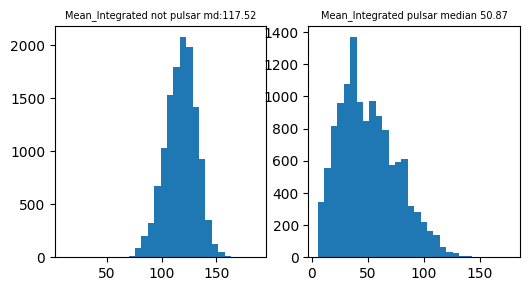

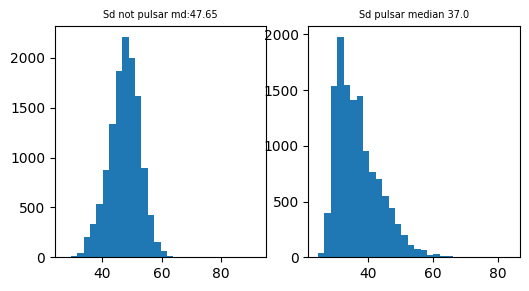

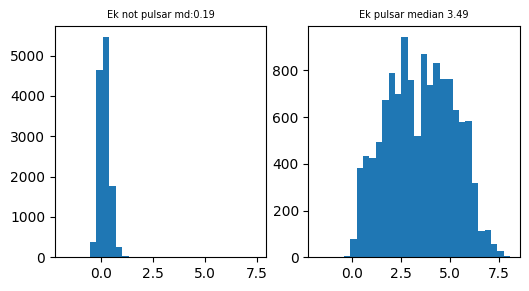

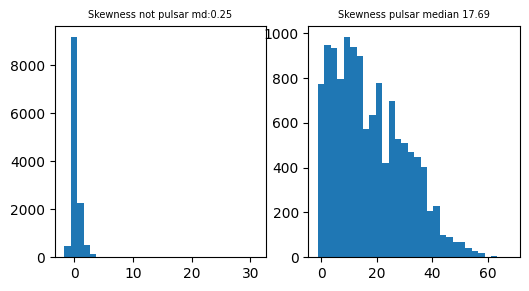

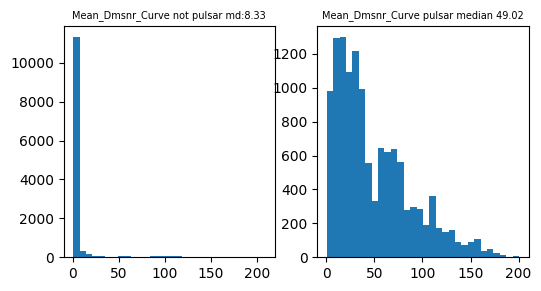

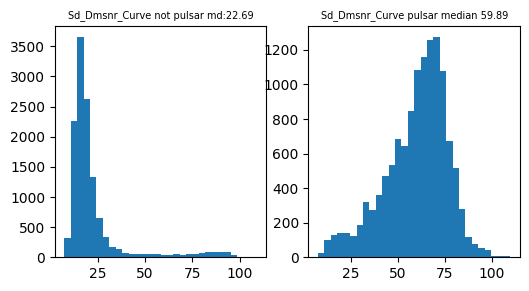

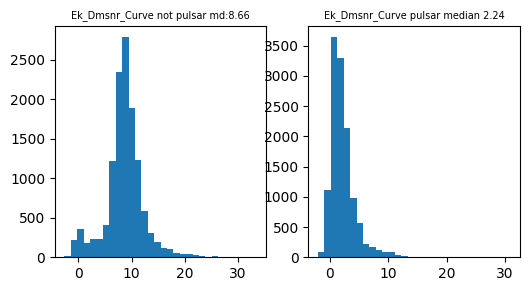

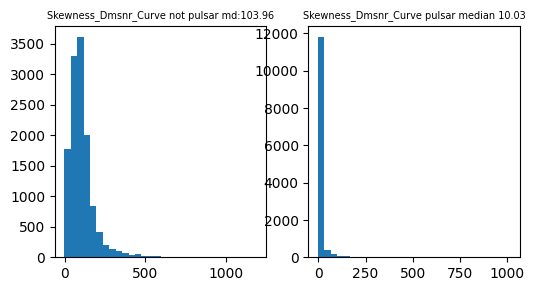

In [8]:
features = ["Mean_Integrated", "SD", "EK",	"Skewness", "Mean_DMSNR_Curve",
            "SD_DMSNR_Curve", "EK_DMSNR_Curve", "Skewness_DMSNR_Curve"]
for ft in features:
    data1 = df[df.Class == 0][ft].sample(len(df[df.Class == 1]))
    data2 = df[df.Class == 1][ft]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    ax1.hist(data1, bins=30)
    ax1.set_title(
        f"{ft.title()} not pulsar md:{round(data1.mean(),2)}", size=7)
    ax2.hist(data2, bins=30)
    ax2.set_title(
        f"{ft.title()} pulsar median {round(data2.mean(),2)}", size=7)
    plt.show()


As expected, it seems from the data that pulsars have a wider variation in the wave length frequencies observed as compared to normal stars

In [9]:
df.Class.value_counts()

0    122856
1     12606
Name: Class, dtype: int64

How to balance the classes?🤔

my choice: let's generate more positive classes,  in this case 122856 - 12606  = 110250

#### using ADASYN to generate more of the smaller class

In [10]:
SPLIT_CUT =  200000  # the size of the training data

x = df.drop("Class", axis=1)
y = df.Class

adasyn = ADASYN()
x , y = adasyn.fit_resample(x, y)

x_train_full, x_test, y_train_full, y_test =  train_test_split(x, y, test_size=0.1)          
x_train, x_valid =  x_train_full[:SPLIT_CUT], x_train_full[SPLIT_CUT:]   
y_train, y_valid =  y_train_full[:SPLIT_CUT], y_train_full[SPLIT_CUT:]



In [11]:
x

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306
...,...,...,...,...,...,...,...,...
245358,50.809215,34.503106,3.704478,20.532757,118.144039,74.620708,0.047508,-0.866736
245359,54.221833,33.084595,3.763399,19.299193,116.940766,70.007157,0.088017,-0.812755
245360,51.740077,33.403279,3.833525,21.534881,121.934818,73.310575,-0.080202,-0.911517
245361,47.973429,32.632805,3.933405,19.197936,126.696747,75.422756,-0.102590,-0.872428


### Standardizing the data

In [12]:
def standardize_features(dataframe: pd.DataFrame, feature_names: list):
    """Standardizes numerical features and returns a dataframe"""
    scaler = StandardScaler()
    df = dataframe.copy()
    df[feature_names] = scaler.fit_transform(df[feature_names])
    return df


In [13]:
# concat with test data first
cut = x.shape[0]
dff = pd.concat([x, test], axis=0)
features = dff.columns.to_list()[:-1] # ignore "id"
dff = standardize_features(dff, features)

x_std = dff[:cut]
test_std = dff[cut:]

In [14]:
x_std = x_std.drop("id", axis=1)
y_std = y

In [15]:
x_train_full_std, x_test_std, y_train_full_std, y_test_std =  train_test_split(x_std, y_std, test_size=0.1)          
x_train_std, x_valid_std =  x_train_full_std[:SPLIT_CUT], x_train_full_std[SPLIT_CUT:]   
y_train_std, y_valid_std =  y_train_full_std[:SPLIT_CUT], y_train_full_std[SPLIT_CUT:]

### Models

In [16]:
R_STATE = 33



Logistic Regression

In [17]:
logreg = LogisticRegression(
    random_state=R_STATE, penalty='l2', C=1.0, solver='lbfgs', max_iter=1000)
logreg.fit(x_train_std, y_train_std)
logreg_pred = logreg.predict(x_test_std)
print(classification_report(y_test_std, logreg_pred))
print(roc_auc_score(y_test_std, logreg_pred))
print("log loss ", log_loss(y_test_std, logreg_pred))



              precision    recall  f1-score   support

           0       0.86      0.91      0.89     12184
           1       0.91      0.86      0.88     12353

    accuracy                           0.89     24537
   macro avg       0.89      0.89      0.89     24537
weighted avg       0.89      0.89      0.89     24537

0.8861665185204399
log loss  4.1101252061274725


RandomForest

In [18]:
rf = RandomForestClassifier(random_state= R_STATE, n_estimators=150, max_depth=None, criterion='gini', n_jobs= -1)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
print(classification_report(y_test, rf_pred))
print("log loss ", log_loss(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     12262
           1       0.98      0.99      0.99     12275

    accuracy                           0.99     24537
   macro avg       0.99      0.99      0.99     24537
weighted avg       0.99      0.99      0.99     24537

auc curve 0.9854875377077726
log loss  0.5229465952042104


XGB

In [32]:
xgbc = xgb.XGBClassifier(
    n_estimators=1500,
    max_depth=6,
    learning_rate=0.12,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=10,
    reg_lambda=1,
    random_state=R_STATE,
    n_jobs=-1,
    objective='binary:logistic',
    eval_metric='logloss',
    early_stopping_rounds=10,
    verbose=1
)

xgbc.fit(x_train, y_train, eval_set=[(x_valid, y_valid)])
xgbc_pred = xgbc.predict(x_test)
print(classification_report(y_test, xgbc_pred))
print("log loss ", log_loss(y_test,xgbc_pred))


[11:10:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-logloss:0.61366
[1]	validation_0-logloss:0.55092
[2]	validation_0-logloss:0.50051
[3]	validation_0-logloss:0.45875
[4]	validation_0-logloss:0.42604
[5]	validation_0-logloss:0.39643
[6]	validation_0-logloss:0.37317
[7]	validation_0-logloss:0.35165
[8]	validation_0-logloss:0.33293
[9]	validation_0-logloss:0.31742
[10]	validation_0-logloss:0.30403
[11]	validation_0-logloss:0.29161
[12]	validation_0-logloss:0.28112
[13]	validation_0-logloss:0.27198
[14]	validation_0-logloss:0.26404
[15]	validation_0-logloss:0.25693
[16]	validation_0-logloss:0.25069
[17]	validation_0-logloss:0.24509
[18]	validation_0-logloss:0.23981
[19]	validation_0-logloss:0.23554
[20]	validation_0-logloss:0.23187
[21]	validation_0-logloss:0.22750
[22]	validation_0-logloss:0.22429
[23]	validation_0-logloss:0.221

Generative Additive Model -  GAM

In [57]:
lgam = LogisticGAM(n_splines=10, lam=1, penalties='auto', max_iter=250)

# interactions = [(0, 1), (2, 3)]
# for inter in interactions:
#     lgam.add_interaction(inter[0], inter[1])

lgam.fit(x_train_std, y_train_std)
lgam_pred = logreg.predict(x_test_std)
print(classification_report(y_test_std, lgam_pred))
print("log loss ", log_loss(y_test_std, lgam_pred))


              precision    recall  f1-score   support

           0       0.86      0.91      0.89     12184
           1       0.91      0.86      0.88     12353

    accuracy                           0.89     24537
   macro avg       0.89      0.89      0.89     24537
weighted avg       0.89      0.89      0.89     24537

log loss  4.1101252061274725


Predictions and submission file

In [30]:
def submission_csv(trained_model, test_data, indexes, filename):
    preds = trained_model.predict_proba(test_data)[:, 1]
    df_ = pd.DataFrame(zip(indexes, preds), columns= ["id", "Class"])
    df_.to_csv(f"{filename}.csv", index=False)
    

In [33]:
#submission_csv(xgbc, test.drop("id", axis=1), test.id, "XGB 1500")

Conclusion: the model that performs better on the cloud test data is the XGB classifier with a moderate Lasso regularization. 